# Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler
import copy

sns.set(font_scale=1.5)

# Functions

# Scalers

In [29]:
def select_scaler(name, train, test):
    if name == 'standard':
        scaler = StandardScaler()
    elif name == 'minmax':
        scaler = MinMaxScaler()
    elif name == 'maxabs':
        scaler = MaxAbsScaler()
    elif name == 'quantile':
        scaler = QuantileTransformer()
    else:
        scaler = RobustScaler()

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    return scaler, train, test

## Make dense neural network

In [30]:
def make_nn_model(input, hidden_layers, output, activation, activation_out, dropout=None):
    model = []
    model.append(tf.keras.layers.Dense(input, activation=activation))
    for hl in hidden_layers:
        model.append(tf.keras.layers.Dense(hl, activation=activation))

    if dropout:
        model.append(tf.keras.layers.Dropout(dropout))
    model.append(tf.keras.layers.Dense(output, activation=activation_out))
    model = tf.keras.Sequential(model)

    return model

## Train Neural Network

In [31]:
def train_nn(x, y, model, opt, loss, patience, epochs, batch_size, scaler=None):
    scores = []
    for i, (train_idx, test_idx) in enumerate(skf.split(x,y)):
        x_train = x[train_idx]
        x_test = x[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        if scaler:
            scaler, x_train_s, x_test_s = select_scaler(scaler, x_train, x_test)
        else:
            x_train_s = x_train
            x_test_s = x_test

        init_w = opt.get_weights()
        model_tmp = tf.keras.models.clone_model(model)
        opt.set_weights(init_w)
        model_tmp.compile(loss=loss, optimizer=opt, metrics=['AUC'])
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
        model_tmp.fit(x_train_s, y_train, epochs=epochs, validation_split=0.15, batch_size=batch_size, callbacks=[callback], verbose=0)

        y_pred = np.round(model_tmp.predict(x_test_s, batch_size=2048, verbose=0))
        scores.append(f1_score(y_test, y_pred, average='macro'))
        print('F1:', scores[-1])
        tf.keras.backend.clear_session()

    return scores

# About data

**Description:**

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In particular, classification systems are widely adopted, which treat the candidate data sets as binary classification problems.

**Attribute information:**

Each candidate is described by 8 continuous variables and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve. These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

**Descriptions courtesy of Ustav Murarka:**

**Integrated Pulse Profile:**
Each pulsar produces a unique pattern of pulse emission known as its pulse profile. It is like a fingerprint of the pulsar. It is possible to identify pulsars from their pulse profile alone. But the pulse profile varies slightly in every period. This makes the pulsar hard to detect. This is because their signals are non-uniform and not entirely stable overtime. However, these profiles do become stable, when averaged over many thousands of rotations.

**DM-SNR Curve:**
Radio waves emitted from pulsars reach earth after traveling long distances in space which is filled with free electrons. Since radio waves are electromagnetic in nature, they interact with these electrons, this interaction results in slowing down of the wave. The important point is that pulsars emit a wide range of frequencies, and the amount by which the electrons slow down the wave depends on the frequency. Waves with higher frequency are sowed down less as compared to waves with higher frequency. i.e. lower frequencies reach the telescope later than higher frequencies. This is called dispersion.

**Dataset Summary:**

* 17,898 total examples.
* 1,639 positive examples.
* 16,259 negative examples.

# Read data

In [32]:
df = pd.read_csv('HTRU_2.csv', names=['mean_p', 'sd_p', 'ek_p', 'sk_p', 'mean_DM-SNR', 'sd_DM-SNR', 'ek_DM-SNR','sk_DM-SNR', 'class'])
df.head()

,mean_p,sd_p,ek_p,sk_p,mean_DM-SNR,sd_DM-SNR,ek_DM-SNR,sk_DM-SNR,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# Check empty values

In [33]:
df.isna().sum()

mean_p         0
sd_p           0
ek_p           0
sk_p           0
mean_DM-SNR    0
sd_DM-SNR      0
ek_DM-SNR      0
sk_DM-SNR      0
class          0
dtype: int64

# Exploratory analysis

In [34]:
df.describe()

,mean_p,sd_p,ek_p,sk_p,mean_DM-SNR,sd_DM-SNR,ek_DM-SNR,sk_DM-SNR,class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


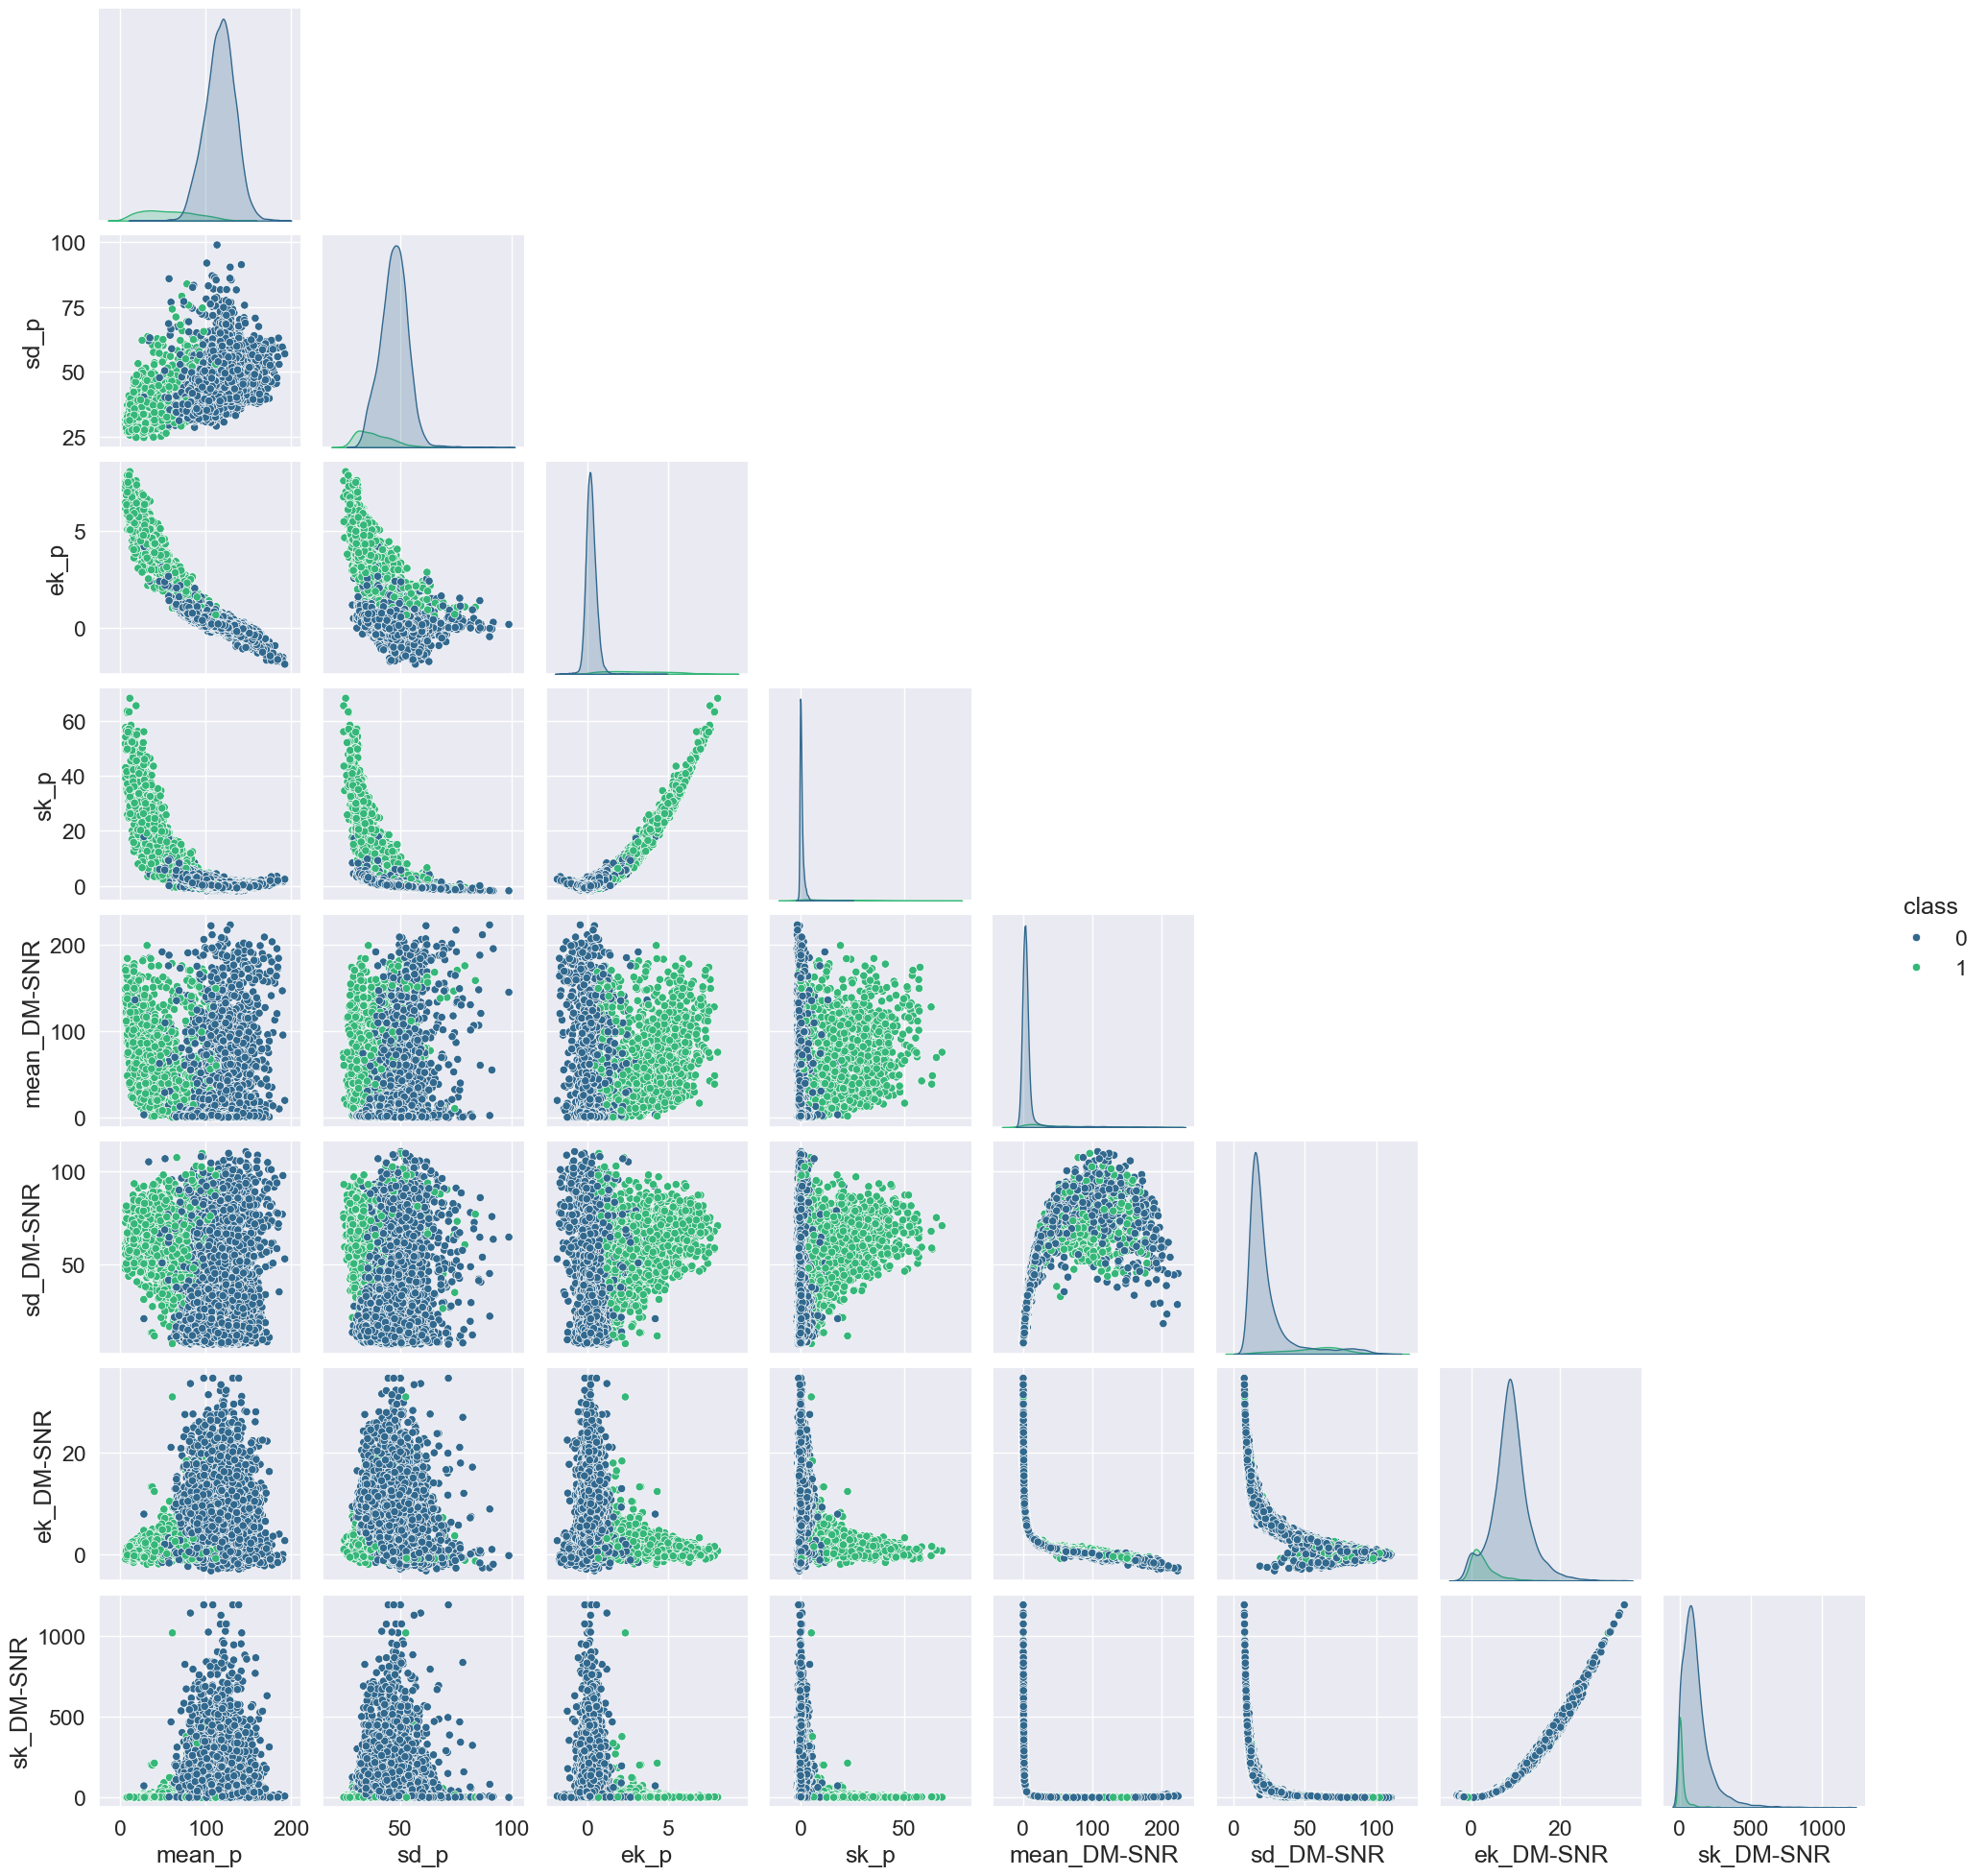

In [8]:
sns.pairplot(df, hue='class', palette='viridis', corner=True)

<Axes: xlabel='class', ylabel='Count'>

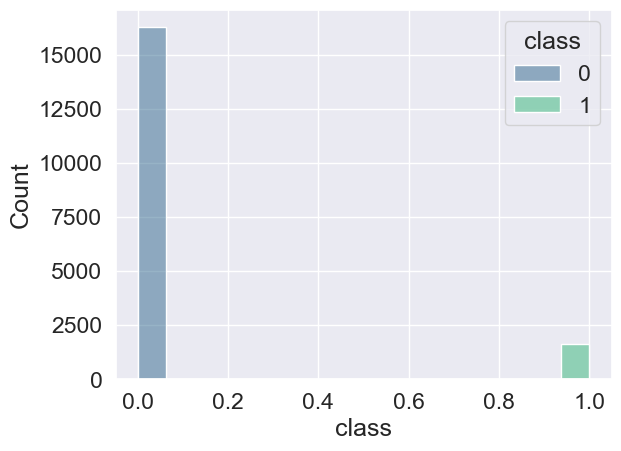

In [9]:
sns.histplot(data=df, x='class', hue='class',palette='viridis')

# Accuracy
$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

# Precision
$Precision = \frac{TP}{TP+FP}$

# Recall
$Recall = \frac{TP}{TP+FN}$

# F1 Score
$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

* TP: true positives
* TN: true negatives
* FP: false positives
* FN: true negatives

# Splitting data

In [35]:
x = df[df.columns[:-1]].to_numpy()
y = df[df.columns[-1]].to_numpy()

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Train base model

In [36]:
model = make_nn_model(8, [128], 1, 'relu', 'sigmoid', 0.15)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3, momentum=0.95, decay=5e-6)
scores = np.array(train_nn(x, y, model, opt, 'binary_crossentropy', 5, 50, 512))
print('Mean:', scores.mean(), 'Std:', scores.std())

F1: 0.8834243289300872
F1: 0.9099437703462563
F1: 0.8327236225921394
F1: 0.8943854254030379
F1: 0.9111608059591695
Mean: 0.8863275906461381 Std: 0.028709425445686488


# Train model with standard scaler

In [39]:
model = make_nn_model(8, [128], 1, 'relu', 'sigmoid', 0.15)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=1e0, momentum=0.9, decay=5e-3)
scores = np.array(train_nn(x, y, model, opt, 'binary_crossentropy', 5, 50, 512, 'standard'))
print('Mean:', scores.mean(), 'Std:', scores.std())

F1: 0.9452462818038521
F1: 0.9068639837579937
F1: 0.9301485670478173
F1: 0.9176389789493709
F1: 0.9369806839369317
Mean: 0.927375699099193 Std: 0.013673598225135187


# Train model with minmax scaler

In [40]:
model = make_nn_model(8, [128], 1, 'relu', 'sigmoid', 0.15)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=1e-1, momentum=0.9, decay=5e-4)
scores = np.array(train_nn(x, y, model, opt, 'binary_crossentropy', 5, 50, 512, 'minmax'))
print('Mean:', scores.mean(), 'Std:', scores.std())

F1: 0.9332948256908085
F1: 0.9345833360030622
F1: 0.9378083968421116
F1: 0.9196554981441848
F1: 0.9414415899438746
Mean: 0.9333567293248084 Std: 0.007408298681644416


In [41]:
model = make_nn_model(8, [128], 1, 'relu', 'sigmoid', 0.15)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=1e-1, momentum=0.9, decay=5e-4)
scores = np.array(train_nn(x, y, model, opt, 'binary_crossentropy', 5, 50, 512, 'quantile'))
print('Mean:', scores.mean(), 'Std:', scores.std())

F1: 0.9180993560047128
F1: 0.9338258713258714
F1: 0.9425990845432253
F1: 0.9194136108170057
F1: 0.9358668556820082
Mean: 0.9299609556745647 Std: 0.009607117772387465


# Select one model

In [42]:
for i, (train_idx, test_idx) in enumerate(skf.split(x,y)):
    x_train = x[train_idx]
    x_test = x[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    break

model = make_nn_model(8, [128], 1, 'relu', 'sigmoid', 0.5)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=1e-1, momentum=0.9, decay=5e-4)
scaler, x_train_s, x_test_s = select_scaler('minmax', x_train, x_test)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train_s, y_train, epochs=50, validation_split=0.2, batch_size=512, callbacks=[callback], verbose=1)

y_pred = np.round(model.predict(x_test_s, batch_size=2048, verbose=0))
print('F1:', f1_score(y_test, y_pred, average='macro'))

Epoch 1/50
23/23 [==============================] - 1s 13ms/step - loss: 0.4305 - auc: 0.4923 - val_loss: 0.1317 - val_auc: 0.8544
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3260 - auc: 0.7707 - val_loss: 0.0956 - val_auc: 0.9590
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.2596 - auc: 0.9305 - val_loss: 0.0645 - val_auc: 0.9619
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1672 - auc: 0.9474 - val_loss: 0.0424 - val_auc: 0.9640
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1292 - auc: 0.9538 - val_loss: 0.0369 - val_auc: 0.9630
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.1194 - auc: 0.9559 - val_loss: 0.0380 - val_auc: 0.9659
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.1168 - auc: 0.9574 - val_loss: 0.0348 - val_auc: 0.9696
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.1124 - auc: 0.9

# History training

Text(0.5, 0, 'epochs')

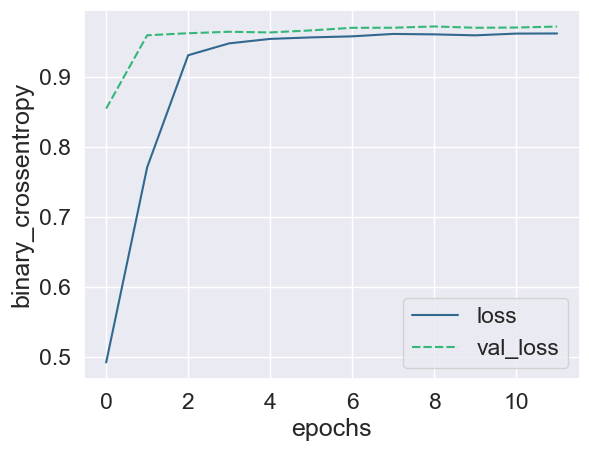

In [45]:
hist = {'loss': history.history['auc'], 'val_loss': history.history['val_auc']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('binary_crossentropy')
plt.xlabel('epochs')

# Results

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.94      0.81      0.87       328

    accuracy                           0.98      3580
   macro avg       0.96      0.90      0.93      3580
weighted avg       0.98      0.98      0.98      3580



Text(0.5, 14.049999999999999, 'Predicted')

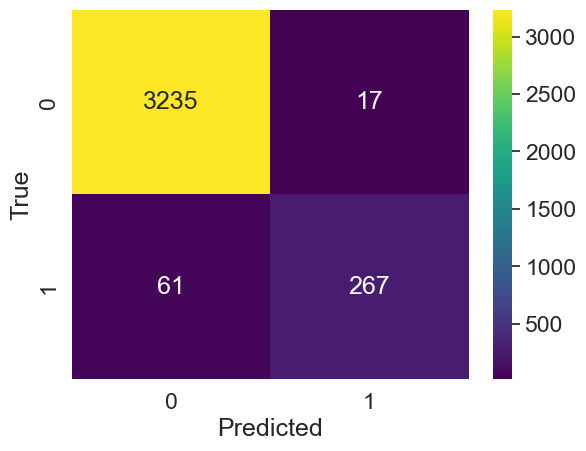

In [47]:
conf = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='viridis')
plt.ylabel('True')
plt.xlabel('Predicted')